## Importing libraries
We start of by importing the libraries that we need for this project.

In [24]:
from sklearn import preprocessing
import PIL
from PIL import Image
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Case 1: images anomaly detection
When we look at the pictures we see alot of dishes and interior/exterior photo's but there are also alot of unhelpfull pictures. These pictures include logo's, people and other random images. There isn't any benifit of having these pictures on a tripadvisor page. Therefor we call these anomalies, these pictures have no need to be on a tripadvisor page, as they bring no information to the customer. Because of this it would be nice to detect these images, this model could then be used to clear up the pages of tripadvisor. 

The detection of these images is called anomaly detection, there are 2 sorts of anomaly detection:
- **Outlier detection:** For this model we need a dataset with both standard pictures and anomaly pictures. 
- **Novelty detection:** For this nodel the trainingset consists only of the standard pictures. The trainingset must be labeled, so it the models are in a supervised fashion.

The dataset of tripadvisor is not labeled, therefor we could use outlier detection. Another choice can be to create a dataset of interiors, exteriors and dishes. This dataset would allow us to use **novelty detection**. For this case we will start of by looking at novelty detection.



sources: 1

### Construction the dataset

The dataset will look like a array of 3 d matrixes.

In [90]:
SIZE = 128
batch = 64

generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2, 
    horizontal_flip=True,
    validation_split=0.2,
    rotation_range=20)


train_generator = generator.flow_from_directory(
    './Images/',
    classes=['restaurants','buffet'],
    target_size=(SIZE, SIZE),
    batch_size=batch,
    subset='training',
    color_mode='grayscale',
    class_mode='input')

validation_generator = generator.flow_from_directory(
    './Images/',
    classes=['restaurants','buffet'],
    target_size=(SIZE, SIZE),
    batch_size=batch,
    subset='validation',
    color_mode='grayscale',
    class_mode='input')

print(train_generator.image_shape)
print(validation_generator.image_shape)

Found 89 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
(128, 128, 1)
(128, 128, 1)


Om te beginnen gaan we greyscale gebruiken, de reden hiervoor is dat we op deze manier de dimensionaliteit reduceren. Dit zorgt dat er minder kans is op overfitting. Fotos met rgb maken het wel mogelijk om een beter model te trainen maar hebben meer kans op overfitting, de oplossingen hiervoor zijn dim reduction of meer data.

In [66]:
## convalutional autoencoder
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(SIZE, SIZE,1)),
      layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      layers.MaxPooling2D((2, 2), padding='same'),
      layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
      layers.MaxPooling2D((2, 2), padding='same'),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
      layers.MaxPooling2D((2, 2), padding='same')])


    self.decoder = tf.keras.Sequential([
      layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
      layers.UpSampling2D((2, 2)),
      layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
      layers.UpSampling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      layers.UpSampling2D((2, 2)),

      layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())



In [78]:
autoencoder.encoder.summary()

autoencoder.build((64,128,128,1))
autoencoder.decoder.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 64, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 32, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 16)        0         
Total params: 23,728
Trainable params: 23,728
Non-trainable params: 0
_________________________________________________

## vragen voor de prof
- Gaan we beter voor 3 anomaly detectors die elk een checken of iets behoord tot een klasse of gaan we voor of kunnen we een dataset samenstellen met alles wat geen anomaly is?
- Als validation data moeten we data voorzien die geen anomaly is. Nemen we hier beast data uit de tripadvisor dataset die we zelf labelden?

In [94]:
history = autoencoder.fit(train_generator,
        epochs=200,
        batch_size=64,
        validation_data=validation_generator, 
        shuffle=True);



Epoch 1/200
2/2 [==============================] - 1s 974ms/step - loss: 0.0149 - val_loss: 0.0165
Epoch 2/200
2/2 [==============================] - 2s 975ms/step - loss: 0.0149 - val_loss: 0.0161
Epoch 3/200
2/2 [==============================] - 2s 1s/step - loss: 0.0148 - val_loss: 0.0161
Epoch 4/200
2/2 [==============================] - 1s 977ms/step - loss: 0.0147 - val_loss: 0.0160
Epoch 5/200
2/2 [==============================] - 2s 550ms/step - loss: 0.0147 - val_loss: 0.0159
Epoch 6/200
2/2 [==============================] - 2s 588ms/step - loss: 0.0144 - val_loss: 0.0161
Epoch 7/200
2/2 [==============================] - 1s 976ms/step - loss: 0.0145 - val_loss: 0.0157
Epoch 8/200
2/2 [==============================] - 2s 1s/step - loss: 0.0144 - val_loss: 0.0158
Epoch 9/200
2/2 [==============================] - 2s 568ms/step - loss: 0.0146 - val_loss: 0.0165
Epoch 10/200
2/2 [==============================] - 1s 914ms/step - loss: 0.0153 - val_loss: 0.0159
Epoch 11/200
2/

KeyboardInterrupt: 

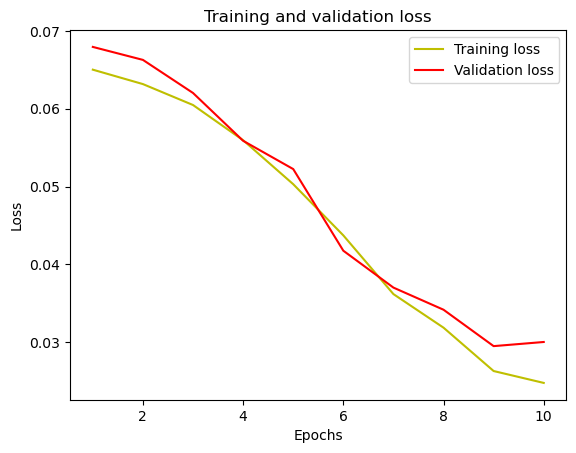

In [92]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In de volgende stappen gaan we eens gaan kijken wat ons model gaat doen met onze trainig data. 
We kunnen hierbij een aantal foto's nemen en kijken wat er mee gebeurt, hoe ziet de foto voor het model eruit en erna

: 

: 

tf.Tensor(
[[0.25333957 0.16122881 0.13313665 ... 0.05664623 0.06242742 0.15147145]
 [0.08478696 0.06028627 0.0486029  ... 0.02293136 0.01819096 0.05586029]
 [0.14973615 0.10154403 0.10102472 ... 0.08609897 0.07386189 0.19971568]
 ...
 [0.31445347 0.14793462 0.12063675 ... 0.04115247 0.02700299 0.02348117]
 [0.15784918 0.10751213 0.07984237 ... 0.0391697  0.03365728 0.08139479]
 [0.16138367 0.02744524 0.0360656  ... 0.06118822 0.03753172 0.04562687]], shape=(15169, 64), dtype=float64)


Ze kunnen anomely detection opdelen in 2 verschillende delen:
- **Outlier detection:** Our input dataset contains examples of both standard events and anomaly events. These algorithms seek to fit regions of the training data where the standard events are most concentrated, disregarding, and therefore isolating, the anomaly events. Such algorithms are often trained in an unsupervised fashion (i.e., without labels). We sometimes use these methods to help clean and pre-process datasets before applying additional machine learning techniques.

- **Novelty detection:** Unlike outlier detection, which includes examples of both standard and anomaly events, novelty detection algorithms have only the standard event data points (i.e., no anomaly events) during training time. During training, we provide these algorithms with labeled examples of standard events (supervised learning). At testing/prediction time novelty detection algorithms must detect when an input data point is an outlier.

sources: 1



## Sources
1. https://pyimagesearch.com/2020/01/20/intro-to-anomaly-detection-with-opencv-computer-vision-and-scikit-learn/
2. https://www.tensorflow.org/tutorials/generative/autoencoder
3. https://github.com/bnsreenu/python_for_microscopists/blob/master/260_image_anomaly_detection_using_autoencoders/260_image_anomaly_detection_using_autoencoders.py#L130

https://www.guru99.com/autoencoder-deep-learning.html

